In [7]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [8]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

data = pd.read_csv('cybersequrity.csv')

print("Размер данных:", data.shape)
print("Первые строки данных:")
print(data.head())
print("\nПропущенные значения:")
print(data.isnull().sum())


X = data.drop(columns=['Class'])
y = data['Class']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = data.drop(columns=['Class'])
y = data['Class']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y, test_size=0.4, stratify=y, random_state=RANDOM_STATE
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=RANDOM_STATE
)
print("Обучающая выборка:", X_train.shape, y_train.shape)
print("Валидационная выборка:", X_val.shape, y_val.shape)
print("Тестовая выборка:", X_test.shape, y_test.shape)

class MalwareDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

batch_size = 64
train_dataset = MalwareDataset(X_train, y_train)
val_dataset = MalwareDataset(X_val, y_val)
test_dataset = MalwareDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Размер данных: (10000, 16)
Первые строки данных:
   svcscan.fs_drivers  callbacks.ngeneric  \
0                  26                   8   
1                  26                   8   
2                  26                   8   
3                  26                   8   
4                  26                   8   

   psxview.not_in_eprocess_pool_false_avg  psxview.not_in_eprocess_pool  \
0                                     0.0                             0   
1                                     0.0                             0   
2                                     0.0                             0   
3                                     0.0                             0   
4                                     0.0                             0   

   callbacks.nanonymous  psxview.not_in_session  psxview.not_in_pslist  \
0                     0                       2                      0   
1                     0                       5                      3   
2      

In [9]:
class MalwareMLP(nn.Module):
    def __init__(self, input_size):
        super(MalwareMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

input_size = X_train.shape[1]
model = MalwareMLP(input_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MalwareMLP(
  (model): Sequential(
    (0): Linear(in_features=15, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [10]:
def train(model, criterion, optimizer, train_loader, val_loader, device, epochs=20):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(features).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * features.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features).squeeze()
                loss = criterion(outputs, labels)
                val_loss += loss.item() * features.size(0)

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return train_losses, val_losses

def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()
    plt.show()


Epoch 1/20 - Train Loss: 0.6671, Val Loss: 0.6496
Epoch 2/20 - Train Loss: 0.6361, Val Loss: 0.6258
Epoch 3/20 - Train Loss: 0.6088, Val Loss: 0.5878
Epoch 4/20 - Train Loss: 0.5744, Val Loss: 0.5537
Epoch 5/20 - Train Loss: 0.5402, Val Loss: 0.5351
Epoch 6/20 - Train Loss: 0.5252, Val Loss: 0.5067
Epoch 7/20 - Train Loss: 0.5123, Val Loss: 0.5019
Epoch 8/20 - Train Loss: 0.4971, Val Loss: 0.4900
Epoch 9/20 - Train Loss: 0.4854, Val Loss: 0.5053
Epoch 10/20 - Train Loss: 0.4832, Val Loss: 0.4767
Epoch 11/20 - Train Loss: 0.4751, Val Loss: 0.4695
Epoch 12/20 - Train Loss: 0.4706, Val Loss: 0.4835
Epoch 13/20 - Train Loss: 0.4686, Val Loss: 0.4676
Epoch 14/20 - Train Loss: 0.4654, Val Loss: 0.4584
Epoch 15/20 - Train Loss: 0.4685, Val Loss: 0.4564
Epoch 16/20 - Train Loss: 0.4573, Val Loss: 0.4565
Epoch 17/20 - Train Loss: 0.4598, Val Loss: 0.4497
Epoch 18/20 - Train Loss: 0.4554, Val Loss: 0.4554
Epoch 19/20 - Train Loss: 0.4494, Val Loss: 0.4493
Epoch 20/20 - Train Loss: 0.4495, Val Lo

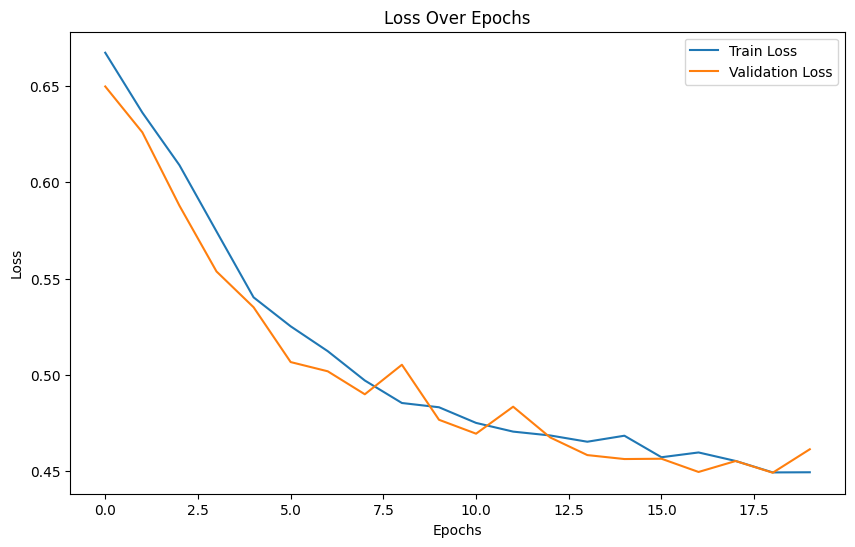


Classification Report:
              precision    recall  f1-score   support

     Neutral       0.78      0.80      0.79       981
   Malicious       0.80      0.78      0.79      1019

    accuracy                           0.79      2000
   macro avg       0.79      0.79      0.79      2000
weighted avg       0.79      0.79      0.79      2000



In [11]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, val_losses = train(model, criterion, optimizer, train_loader, val_loader, device, epochs=20)
plot_losses(train_losses, val_losses)

def evaluate(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features).squeeze()
            preds = (outputs > 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Neutral', 'Malicious']))

evaluate(model, test_loader, device)

Epoch 1/30 - Train Loss: 0.6622, Val Loss: 0.6418
Epoch 2/30 - Train Loss: 0.6141, Val Loss: 0.6109
Epoch 3/30 - Train Loss: 0.5851, Val Loss: 0.5827
Epoch 4/30 - Train Loss: 0.5691, Val Loss: 0.5946
Epoch 5/30 - Train Loss: 0.5657, Val Loss: 0.5498
Epoch 6/30 - Train Loss: 0.5526, Val Loss: 0.5589
Epoch 7/30 - Train Loss: 0.5527, Val Loss: 0.5761
Epoch 8/30 - Train Loss: 0.5413, Val Loss: 0.5381
Epoch 9/30 - Train Loss: 0.5333, Val Loss: 0.5248
Epoch 10/30 - Train Loss: 0.5316, Val Loss: 0.5304
Epoch 11/30 - Train Loss: 0.5297, Val Loss: 0.5173
Epoch 12/30 - Train Loss: 0.5239, Val Loss: 0.5403
Epoch 13/30 - Train Loss: 0.5248, Val Loss: 0.5461
Epoch 14/30 - Train Loss: 0.5162, Val Loss: 0.5475
Epoch 15/30 - Train Loss: 0.5114, Val Loss: 0.5274
Epoch 16/30 - Train Loss: 0.5154, Val Loss: 0.5154
Epoch 17/30 - Train Loss: 0.5102, Val Loss: 0.5185
Epoch 18/30 - Train Loss: 0.5074, Val Loss: 0.5264
Epoch 19/30 - Train Loss: 0.5101, Val Loss: 0.5211
Epoch 20/30 - Train Loss: 0.5075, Val Lo

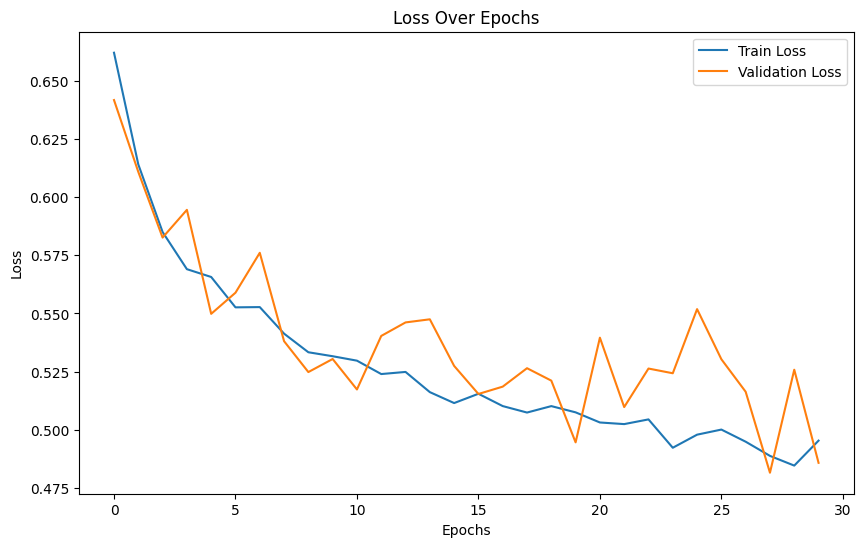


Classification Report:
              precision    recall  f1-score   support

     Neutral       0.81      0.66      0.73       981
   Malicious       0.72      0.85      0.78      1019

    accuracy                           0.76      2000
   macro avg       0.77      0.76      0.76      2000
weighted avg       0.77      0.76      0.76      2000



In [12]:
class ImprovedMalwareMLP(nn.Module):
    def __init__(self, input_size, dropout_p=0.5):
        super(ImprovedMalwareMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

input_size = X_train.shape[1]
improved_model = ImprovedMalwareMLP(input_size, dropout_p=0.4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
improved_model.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(improved_model.parameters(), lr=0.001)

train_losses, val_losses = train(improved_model, criterion, optimizer, train_loader, val_loader, device, epochs=30)
plot_losses(train_losses, val_losses)
evaluate(improved_model, test_loader, device)